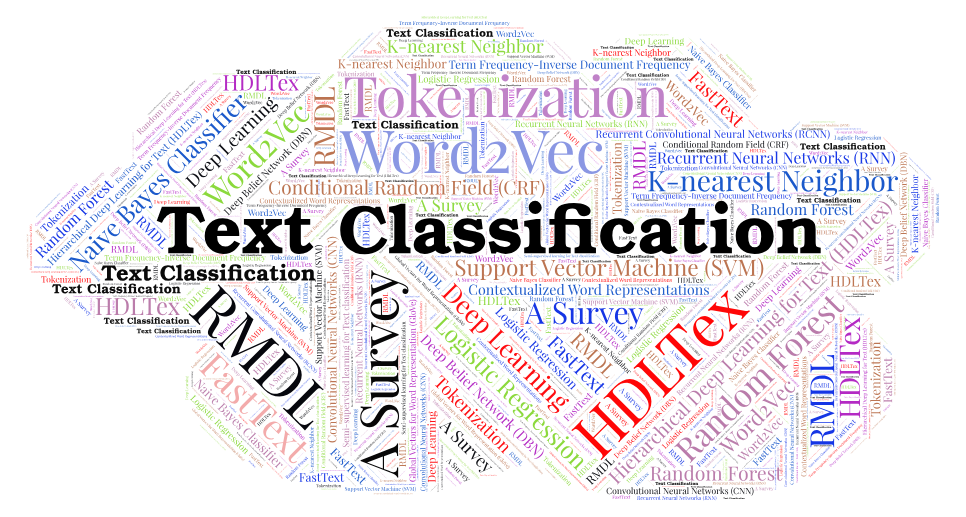


# **Import Libraries**



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string, nltk
import re
import os
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.metrics import accuracy_score, precision_score,recall_score, classification_report


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Embedding,LSTM, Dropout,SimpleRNN,GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from keras.callbacks import EarlyStopping


In [3]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!apt install unzip
!unzip "glove.6B.zip"

--2023-09-19 17:28:57--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-09-19 17:28:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-09-19 17:31:37 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is alr

In [4]:
#!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
#!apt install unzip
#!unzip "glove.twitter.27B.zip"

In [5]:
punct = nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
nltk.download('omw-1.4')
lemma = WordNetLemmatizer()
stemm = PorterStemmer()
from bs4 import BeautifulSoup
# Downloading stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
train_data = pd.read_csv("/content/news_topic_train.csv", engine = "python")

In [32]:
train_data.head()

,Id,title,text,label
0,1490,Oscars steer clear of controversy,The Oscars nominations list has left out som...,entertainment
1,2001,Charvis set to lose fitness bid,Flanker Colin Charvis is unlikely to play an...,sport
2,1572,Corbett attacks 'dumbed-down TV',Ronnie Corbett has joined fellow comedy star...,entertainment
3,1840,Sociedad set to rescue Mladenovic,Rangers are set to loan out-of-favour midfie...,sport
4,610,Doors open at biggest gadget fair,Thousands of technology lovers and industry ...,tech


In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      1780 non-null   int64 
 1   title   1780 non-null   object
 2   text    1780 non-null   object
 3   label   1780 non-null   object
dtypes: int64(1), object(3)
memory usage: 55.8+ KB


In [34]:
train_data.isna().sum()

Id       0
title    0
text     0
label    0
dtype: int64

In [35]:
#train_data.drop(['Id'], axis=1,inplace = True)
#train_data.drop(['title'], axis=1,inplace = True)


In [36]:
train_data['text'] = train_data['text'] + " " + train_data['title']
del train_data['title']

In [37]:
len(max(train_data["text"][:]))

2436

**Text preprocessing**

In [38]:
#Removing the Html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [39]:
#Removing the square brackets and urls
def remove_between_square_brackets(text):
    text = re.sub('\[[^]]*\]', '', text)
    return re.sub(r'http\S+', '', text)

In [40]:
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

In [41]:
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [42]:
#Apply function on text column
train_data['text']=train_data['text'].apply(denoise_text)

In [43]:
len(train_data['text'].iloc[0])

2744

- Creating mapped dictionary **`Id`** with the **`label`**  column and vice versa.

In [44]:
category_to_id = {'business':0, 'tech':1, 'politics':2, 'sport':3, 'entertainment':4}
id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [45]:
train_data["label"] = train_data["label"].replace(category_to_id)
train_data.head()

,Id,text,label
0,1490,Oscars nominations list left controversial fil...,4
1,2001,Flanker Colin Charvis unlikely play part Wales...,3
2,1572,Ronnie Corbett joined fellow comedy stars Vict...,4
3,1840,Rangers set loan out-of-favour midfielder Drag...,3
4,610,Thousands technology lovers industry experts g...,1


In [46]:
max_features = 100000
maxlen = 300

**Tokenize the data**

In [47]:
X_train  = train_data["text"]
y_train = train_data["label"]

In [48]:
y_train

0       4
1       3
2       4
3       3
4       1
       ..
1775    4
1776    0
1777    0
1778    0
1779    0
Name: label, Length: 1780, dtype: int64

In [49]:
tokenizer = Tokenizer(num_words= max_features)
#here the mapping is created,  word to integer mapping (only for the top 10000)
tokenizer.fit_on_texts(X_train)
#here the mapping is applied to the sentences
vector = tokenizer.texts_to_sequences(X_train)

### Glove Iplementation

In [50]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

In [51]:
glove_input_file = 'glove.6B.300d.txt'

In [52]:
glove_output_file = "word2vec.txt"

In [53]:
embeddings_index = dict()

f = open(glove_input_file)
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [54]:
from numpy import zeros

In [55]:
embedding_matrix = zeros((max_features, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

**Pad the sequences**

In [56]:
X_train_pad = pad_sequences(vector, maxlen=maxlen)

In [57]:
from tensorflow.keras.utils import to_categorical
Y= to_categorical((train_data['label']))
Y

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [58]:
Y.shape

(1780, 5)

## Model Building

In [67]:
import tensorflow as tf

from tensorflow.keras import optimizers
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

**LSTM Model Building**

In [68]:
test_model = Sequential()
test_model.add(Embedding(max_features,maxlen,weights=[embedding_matrix],trainable=False))
test_model.add(LSTM(units=128))
test_model.add(Dropout(0.25))
test_model.add(Dense(5, activation='softmax'))
test_model.compile(loss ='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

In [65]:
print(test_model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         30000000  
                                                                 
 lstm_1 (LSTM)               (None, 128)               219648    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 30220293 (115.28 MB)
Trainable params: 220293 (860.52 KB)
Non-trainable params: 30000000 (114.44 MB)
_________________________________________________________________
None


In [62]:
#early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [69]:
history2 = test_model.fit(X_train_pad,Y, epochs= 10, batch_size=256, validation_split=0.2)

Epoch 1/10
6/6 [==============================] - 18s 3s/step - loss: 1.0159 - accuracy: 0.6538 - val_loss: 0.3768 - val_accuracy: 0.8848
Epoch 2/10
6/6 [==============================] - 13s 2s/step - loss: 0.3654 - accuracy: 0.8926 - val_loss: 0.3891 - val_accuracy: 0.8792
Epoch 3/10
6/6 [==============================] - 13s 2s/step - loss: 0.2518 - accuracy: 0.9291 - val_loss: 0.2191 - val_accuracy: 0.9382
Epoch 4/10
6/6 [==============================] - 13s 2s/step - loss: 0.1307 - accuracy: 0.9628 - val_loss: 0.1676 - val_accuracy: 0.9551
Epoch 5/10
6/6 [==============================] - 13s 2s/step - loss: 0.0926 - accuracy: 0.9726 - val_loss: 0.1403 - val_accuracy: 0.9551
Epoch 6/10
6/6 [==============================] - 13s 2s/step - loss: 0.0462 - accuracy: 0.9888 - val_loss: 0.1765 - val_accuracy: 0.9438
Epoch 7/10
6/6 [==============================] - 13s 2s/step - loss: 0.0493 - accuracy: 0.9874 - val_loss: 0.1438 - val_accuracy: 0.9494
Epoch 8/10
6/6 [==================

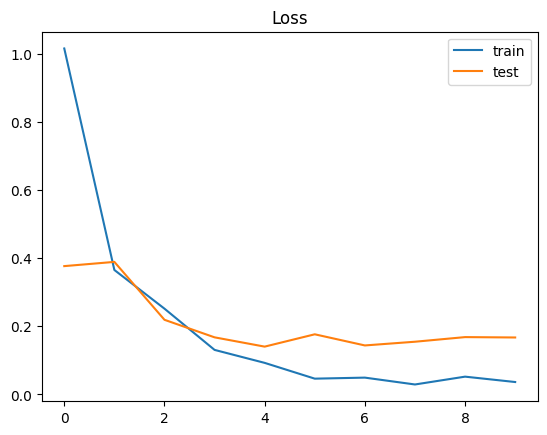

In [70]:
plt.title('Loss')
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show();

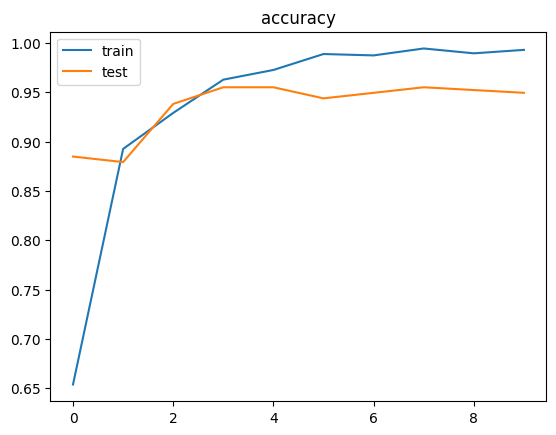

In [71]:
plt.title('accuracy')
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [72]:
news_test =pd.read_csv("/content/news_topic_test.csv")

In [74]:
news_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      445 non-null    int64 
 1   title   445 non-null    object
 2   text    445 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.6+ KB


In [75]:
news_test['text']=news_test['text'].apply(denoise_text)

In [76]:
tokenized_test = tokenizer.texts_to_sequences(news_test['text'])
test = sequence.pad_sequences(tokenized_test, maxlen=maxlen )

In [77]:
pred_y=test_model.predict(test)

14/14 [==============================] - 3s 179ms/step


In [78]:
pred_y

array([[4.3663359e-04, 1.8092894e-04, 9.9602127e-01, 4.6023238e-04,
        2.9009765e-03],
       [9.5705446e-03, 9.4790649e-01, 2.3991022e-02, 1.0253570e-02,
        8.2784072e-03],
       [2.5814825e-03, 1.0593884e-02, 1.4098732e-03, 7.1681151e-03,
        9.7824663e-01],
       ...,
       [9.9773550e-01, 1.9159215e-04, 1.1432305e-03, 1.5752712e-04,
        7.7209866e-04],
       [2.6833698e-02, 2.2940144e-01, 1.6346389e-01, 5.5780071e-01,
        2.2500204e-02],
       [1.1282116e-02, 9.8614663e-01, 9.2903420e-04, 6.5095292e-04,
        9.9122257e-04]], dtype=float32)

In [79]:
id_to_category = {0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

In [80]:
final_pred = np.round(pred_y).astype(int)
final_pred

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]])

In [81]:
y = np.argmax(final_pred, axis=-1)


In [82]:
y

array([2, 1, 4, 2, 0, 4, 3, 0, 0, 0, 2, 0, 4, 2, 1, 1, 3, 1, 2, 1, 2, 3,
       2, 1, 4, 0, 1, 0, 0, 4, 4, 0, 4, 1, 2, 0, 2, 3, 3, 4, 3, 0, 2, 4,
       3, 3, 3, 1, 2, 3, 1, 1, 0, 2, 1, 0, 0, 0, 2, 2, 2, 1, 1, 2, 4, 1,
       2, 2, 0, 4, 0, 3, 3, 1, 2, 3, 0, 0, 2, 0, 3, 3, 2, 1, 1, 3, 3, 0,
       0, 4, 0, 2, 0, 2, 4, 2, 1, 0, 2, 0, 2, 0, 3, 2, 4, 0, 2, 3, 1, 0,
       1, 3, 1, 2, 0, 4, 1, 1, 1, 2, 1, 0, 2, 0, 3, 3, 3, 1, 2, 1, 4, 1,
       0, 4, 4, 0, 2, 2, 1, 3, 3, 2, 0, 2, 3, 0, 3, 1, 2, 0, 4, 0, 2, 3,
       3, 4, 1, 2, 2, 1, 3, 1, 1, 0, 3, 1, 2, 3, 3, 1, 0, 3, 3, 0, 0, 3,
       0, 0, 4, 4, 2, 4, 2, 0, 3, 4, 1, 4, 3, 2, 2, 4, 2, 3, 3, 1, 0, 0,
       3, 3, 4, 0, 2, 3, 2, 0, 0, 0, 4, 3, 0, 2, 3, 0, 2, 2, 3, 3, 2, 3,
       2, 2, 0, 1, 0, 0, 0, 0, 0, 1, 4, 4, 1, 0, 3, 3, 1, 2, 3, 2, 3, 0,
       0, 4, 0, 2, 2, 2, 3, 2, 0, 4, 3, 2, 0, 3, 0, 4, 4, 3, 0, 3, 2, 1,
       4, 0, 0, 4, 1, 4, 1, 0, 2, 1, 0, 4, 0, 0, 3, 2, 2, 3, 2, 2, 1, 3,
       0, 1, 1, 3, 2, 3, 2, 0, 0, 2, 2, 3, 0, 3, 4,

In [83]:
df = pd.DataFrame(y, columns = ["label"])


In [84]:
submission = pd.DataFrame({'Id':news_test['Id'],'label':df['label']})


In [85]:
submission = submission.replace(id_to_category)
submission.to_csv('Submission.csv',header=False,index=False)
